# <center> </center>
# <center> 11a. DCC Application
## <center> ECO374

If using Colab, mount Google Drive and set path to files

In [1]:
import os
IN_COLAB = 'COLAB_GPU' in os.environ 
if IN_COLAB:
  from google.colab import drive; mount_path = '/content/drive'
  not os.path.ismount(mount_path) and drive.mount(mount_path)
  os.chdir('/content/drive/MyDrive/Colab Notebooks/Python_code') # Set Python file directory

Set up R for Python

In [2]:
import R_for_Python_setup as RPY
RPY.setup_R()
ro, pandas2ri, StrVector = RPY.initialize_rpy2()
%load_ext rpy2.ipython

R installed
Operating system: Windows
Development tool: Anaconda


Load R packages

In [3]:
R_packages = ['rugarch']
RPY.load_R_packages(R_packages)
R_packages = ['rmgarch'] # needs to be installed and loaded separately from rugarch
RPY.load_R_packages(R_packages)

R packages loaded: rugarch
R packages loaded: rmgarch


Load Python packages

In [4]:
pth_packages = ['yfinance']
import subprocess, sys
for pkg in pth_packages: subprocess.run([sys.executable, '-m', 'pip', 'install', pkg, '--quiet'], check=True)
import numpy as np, pandas as pd, matplotlib.pyplot as plt, yfinance as yf, matplotlib.dates as mdates
import warnings; warnings.filterwarnings("ignore")

  # 1. Data
The data are the same as in 10. Multivariate Volatility. Specify portfolio assets, [tickers](https://finance.yahoo.com/lookup/), and their colors

In [5]:
names = ["Pfizer", "AstraZeneca", "Johnson&Johnson", "Merck"]

tickers = ["PFE", "AZN", "JNJ", "MRK"]

color_palette = ["lightblue3", "darkorange", "yellowgreen", "cyan3"]

Obtain data automatically and extract Close prices

In [6]:
data = yf.download(tickers, start="2022-06-01", end="2025-03-01", progress=False,
                   auto_adjust=False, group_by='ticker')
prices = pd.DataFrame()
for ticker in tickers:
    prices[ticker] = data[ticker]['Close']
returns = np.log(prices/prices.shift(1)).dropna()*100 # in % terms

Transfer data from Python to R

In [7]:
ro.globalenv['returns'] = returns 
ro.globalenv['tickers'] = StrVector(tickers) 

# 2. DCC Model

Fit a DCC model to the returns data

In [8]:
%%R
# Univariate GARCH model specification
uni_garch <- ugarchspec(
             variance.model = list(model = 'sGARCH', garchOrder = c(1,1)),
             mean.model = list(armaOrder = c(1,1)))

# Replicate the univariate model for each dimension
dim <- ncol(returns)
rep_garch <- multispec(replicate(dim, uni_garch))

# Formulate the DCC model
DCC_model <- dccspec(uspec = rep_garch, dccOrder = c(1, 1), model = "DCC")

# Fit the model to the data
DCC_fit <- dccfit(spec = DCC_model, data = returns, solver = "solnp")

Extract fitted dynamic correlations (3D array with shape n_assets x n_assets x T)

In [9]:
%%R
Cor_array <- rcor(DCC_fit)  

Format into 2D array, label names

In [10]:
%%R
pairs <- combn(tickers, 2)
pair_names <- apply(pairs, 2, function(x) paste(x, collapse = "_"))
Cor_long <- data.frame()

for (j in seq_len(ncol(pairs))) {
  i1 <- which(tickers == pairs[1, j])
  i2 <- which(tickers == pairs[2, j])
  
  temp <- data.frame(
    Pair = pair_names[j],
    Correlation = Cor_array[i1, i2, ]
  )
  
  rownames(temp) <- NULL
  Cor_long <- rbind(Cor_long, temp)
}

In [11]:
Cor_long = pandas2ri.rpy2py(ro.globalenv['Cor_long'])

In [12]:
# set datetime index for long format
unique_dates = returns.index  
n_pairs = Cor_long.shape[0] // len(unique_dates)
Cor_long['Date'] = pd.to_datetime(np.tile(unique_dates, n_pairs))

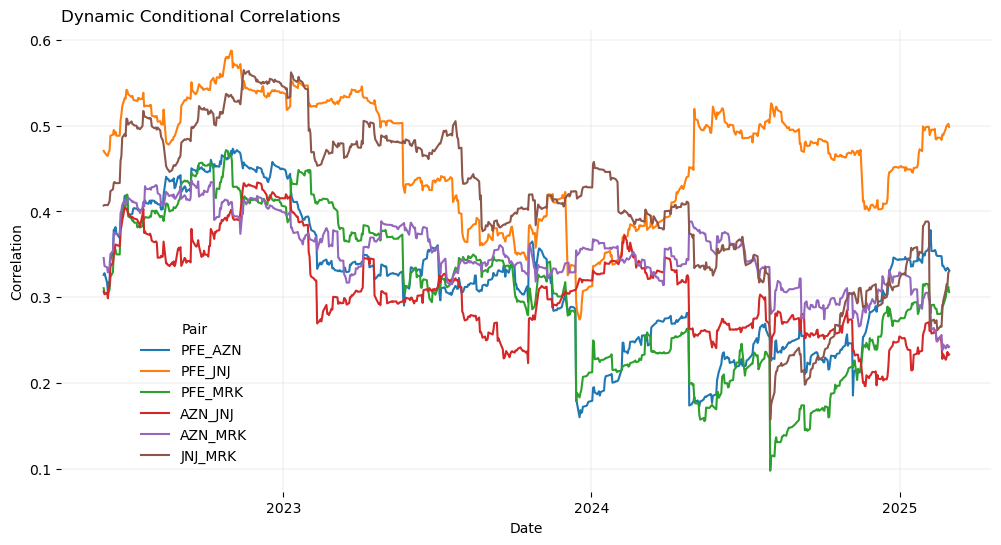

In [13]:
plt.figure(figsize=(12, 6))

for pair in Cor_long['Pair'].unique():
    data = Cor_long[Cor_long['Pair'] == pair]
    plt.plot(data['Date'], data['Correlation'], label=pair)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xlabel('Date')
plt.ylabel('Correlation')
plt.title('Dynamic Conditional Correlations',loc='left')
plt.legend(title='Pair', loc=(0.08, 0.05), frameon=False)
plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.box(False)
plt.show()

# 3. Forecast

Correlation matrix, 1 step ahead

In [14]:
%%R
h_steps <- 1
fct <- rmgarch::dccforecast(DCC_fit, n.ahead=h_steps)
C <- rcor(fct)[[1]][,,h_steps]
C <- round(C, digits=2)
print(C)

     PFE  AZN  JNJ  MRK
 1.00 0.33 0.50 0.31
 0.33 1.00 0.24 0.25
 0.50 0.24 1.00 0.34
 0.31 0.25 0.34 1.00


Covariance matrix, 1 step ahead

In [15]:
%%R
S <- rcov(fct)[[1]][,,h_steps] 
S <- round(S, digits=2)
print(S)

     PFE  AZN  JNJ  MRK
 2.15 0.65 0.75 0.64
 0.65 1.73 0.32 0.45
 0.75 0.32 1.03 0.47
 0.64 0.45 0.47 1.93
